# Analysis notebook for: How much research shared on Facebook is hidden from public view?

This notebook produces all results and figures in the article.

Figures are plotted to the *figures/* directory.

In order to re-produce the plots without interacting with the notebook use `jupyter nbconvert --execute analysis.ipynb`

**Outline**

1. Coverage
    1. Comparison of AES, POS, and TW
    2. Facebook coverage in detail
    3. Coverage by disciplines
        1. Disciplinary breakdown of Facebook methods
2. Engagement Counts
    1. Comparison of AES, POS, and TW
    2. Facebook counts in detail
    3. Facebook counts by discipline

In [1]:
from pathlib import Path

import gspread
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from gspread_dataframe import get_as_dataframe, set_with_dataframe
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib_venn import venn2, venn3, venn3_circles
from oauth2client.service_account import ServiceAccountCredentials
from scipy import stats
from scipy.optimize import curve_fit
from tqdm.auto import tqdm

tqdm.pandas()

In [2]:
# Implementation of partial log binning following Milojević (2010)
def thresh(bin_size):
    x = 1
    while True:
        diff = np.log10(x+1) - np.log10(x)
        if diff < bin_size:
            return x +1
        x = x + 1

def partial_log_binning(data_counts, bin_size=0.1):
    n_bins = 1/bin_size
    binning_threshold = thresh(bin_size)

    log_data = np.log10(data_counts)
    log_index = np.log10(log_data.index)

    logbins = np.linspace(np.log10(binning_threshold)+0.1,
                          np.log10(max(data)),
                          ((np.log10(max(data))-np.log10(binning_threshold)+0.1)//0.1)+1)

    binned_xs = []
    binned_vals = []      
    
    for i in range(1, binning_threshold+1):      
        if i in log_data.index:
            binned_vals.append(log_data.loc[i])
            binned_xs.append(np.log10(i))
    
    for b in logbins:       
            vals = (b-.05 <= log_index) & (log_index < b+.05)
            vs = data_counts[vals]
            if len(vs)>0:
                n = np.ceil(10**(b+.05) - 10**(b-.05))
                if n == 0:
                    continue
                binned_vals.append(np.log10(vs.sum()/n))
                binned_xs.append(b)
    return binned_xs, binned_vals  

# Configuration

In [65]:
plt.rcParams.update({
    'font.family':'sans-serif',
    'font.size': 16.0,
    'text.usetex': False,
    'figure.figsize': (11.69,8.27)
})

# Seaborn styles
sns.set_style("whitegrid")

# Color palette
cm = "Paired"
cp3 = sns.color_palette(cm, 3)
cp10 = sns.color_palette(cm, 10)

In [4]:
### Optional ###
# Set up GSpread connection to push dataframes to Google Spreadsheets
# Instructions can be found at https://gspread.readthedocs.io/en/latest/

# scope = ['https://spreadsheets.google.com/feeds',
#          'https://www.googleapis.com/auth/drive']

# credentials = ServiceAccountCredentials.from_json_keyfile_name('My Project-d9fa71152fe8.json', scope)

# gc = gspread.authorize(credentials)
# sh =  gc.open("PLOS Paper - Tables")

push_to_gspread = False

# Load data, preprocessing, dropping years + bad results

In [5]:
articles_csv = "data/articles.csv"
responses_csv = "data/responses.csv"

figs = Path("figures")

In [116]:
articles = pd.read_csv(articles_csv, index_col="doi", parse_dates=['publication_date'])
all_responses = pd.read_csv(responses_csv, index_col="id", parse_dates=['received_at', 'og_updated_time', 'publication_date', 'added_on'])

# add year and metrics
all_responses = all_responses.merge(articles[['year', 'AES', 'AER', 'AEC']], left_on="doi", right_index=True, how="left")

In [117]:
# Limit responses to those articles that received some forms of engagement
responses = all_responses
responses = responses.replace(0, np.nan)
responses = responses.dropna(subset=['shares', 'reactions', 'comments'], how="all")

In [118]:
all_shares = set(articles['AES'].dropna().index.tolist())
all_reactions = set(articles['AER'].dropna().index.tolist())
all_comments = set(articles['AEC'].dropna().index.tolist())

any_engagement = all_shares.union(all_reactions).union(all_comments)

In [119]:
metrics = ['AES', 'AER', 'AEC']

## Methods

In [142]:
df = pd.DataFrame(columns=["Count"])
df.loc['Number of articles', "Count"] = len(articles)
df.loc['Number of URLs', "Count"] = len(articles) * 10
df.loc['--------', "Count"] = None
df.loc['Number of successful responses', "Count"] = len(all_responses)
df.loc['Number of non-zero responses', "Count"] = len(responses)
df.loc['Number of zero-responses', "Count"] = len(all_responses) - len(responses)
df.loc['---------', "Count"] = None
df.loc['Number of unique URLs', "Count"] = responses.url.nunique()
df.loc['Number of unique queries', "Count"] = responses.query_id.nunique()
df.loc['Number of unique OG IDs', "Count"] = responses.og_id.nunique()
df.loc['Number of unique DOIs', "Count"] = responses.doi.nunique()

df

,Count
Number of articles,61848.0
Number of URLs,618480.0
--------,NaN
Number of successful responses,69948.0
Number of non-zero responses,32887.0
Number of zero-responses,37061.0
---------,NaN
Number of unique URLs,32887.0
Number of unique queries,32887.0
Number of unique OG IDs,22215.0


In [120]:
articles[metrics].describe().round(2)

,AES,AER,AEC
count,21415.00,13825.00,10259.00
mean,8.81,53.54,23.99
std,136.32,475.45,311.97
min,1.00,1.00,1.00
25%,1.00,4.00,2.00
50%,2.00,16.00,6.00
75%,4.00,46.00,15.00
max,12473.00,36030.00,15840.00


## Results

### What is the overall coverage of articles?

In [165]:
temp = articles[metrics].dropna(how="all")
df = articles[metrics].count().to_frame("n")
df["% (n={})".format(len(articles))] = df['n'].div(len(articles)/100).round(2)
df['% (n={})'.format(len(temp))] = df['n'].div(len(temp)/100).round(2)
df

,n,% (n=61848),% (n=21674)
AES,21415,34.63,98.81
AER,13825,22.35,63.79
AEC,10259,16.59,47.33


#### What does the breakdown of URLs per article look like?

In [175]:
cov_urls_counts = responses[['doi', 'og_id']].groupby("doi").count().og_id.value_counts().reset_index()
cov_urls_counts['%'] = 100 * cov_urls_counts.og_id.div(cov_urls_counts.og_id.sum())
cov_urls_counts.columns = ["Number of URLs", "Articles", "Articles [%]"]

cov_urls_counts = cov_urls_counts.set_index("Number of URLs")

if push_to_gspread:
    wks = sh.worksheet("Coverage - Number of URLs")
    set_with_dataframe(wks, cov_urls_counts.round(1).reset_index())

cov_urls_counts.round(1)

,Articles,Articles [%]
Number of URLs,,
1,12344,57.0
2,7702,35.5
3,1442,6.7
4,142,0.7
5,29,0.1
6,8,0.0
7,4,0.0
8,3,0.0


In [176]:
x = responses[['doi', 'og_id']].groupby("doi").nunique().og_id.value_counts().reset_index()
x['%'] = 100*x.og_id.div(x.og_id.sum())
x.columns = ["Objects per Article", "Articles", "Articles [%]"]
x = x.set_index("Objects per Article")
x.round(1)

,Articles,Articles [%]
Objects per Article,,
1,21134,97.5
2,539,2.5
3,1,0.0


In [177]:
x = responses[['doi', 'og_id']].groupby("doi")["og_id"].nunique()
mult_ogids = x[x>1].keys()

y = responses[responses.doi.isin(mult_ogids)]
z = y[['doi', 'og_id', 'type']].groupby(["doi", "og_id"])['type'].apply(lambda x: ", ".join(sorted(x))).reset_index()
zz = z.groupby("doi")['type'].apply(lambda x: " -- ".join(sorted(x)))

zz.map(lambda x: "pdf" in x).sum()

504

In [178]:
cov_urls_types = responses.type.value_counts().reset_index()
cov_urls_types['%'] = 100*cov_urls_types.type.div(cov_urls_types.type.sum())
cov_urls_types.columns = ["URL Type", "FB Objects", "FB Objects [%]"]

cov_urls_types = cov_urls_types.set_index("URL Type")

if push_to_gspread:
    wks = sh.worksheet("Coverage - URL Types")
    set_with_dataframe(wks, cov_urls_types.round(1).reset_index())

cov_urls_types.round(1)

,FB Objects,FB Objects [%]
URL Type,,
landing,21515,65.4
doi_old,4927,15.0
metrics,4348,13.2
doi,982,3.0
pdf,644,2.0
authors,296,0.9
related,96,0.3
comments,76,0.2
pmid,2,0.0


In [206]:
df = responses.groupby(['type', 'year']).size().to_frame('size').reset_index()
df = df.pivot(columns="year", index="type", values="size")
df = df.apply(lambda x: 100*x/x.sum()).sort_values(by=2017, ascending=False)

df.round(1)

year,2015,2016,2017
type,,,
landing,57.6,68.9,76.5
doi_old,15.5,19.8,7.5
doi,1.4,2.1,7.3
pdf,0.6,1.5,5.4
authors,0.3,1.2,1.7
comments,0.1,0.2,0.6
related,0.1,0.4,0.6
metrics,24.3,6.0,0.5
pmc,0.0,NaN,NaN


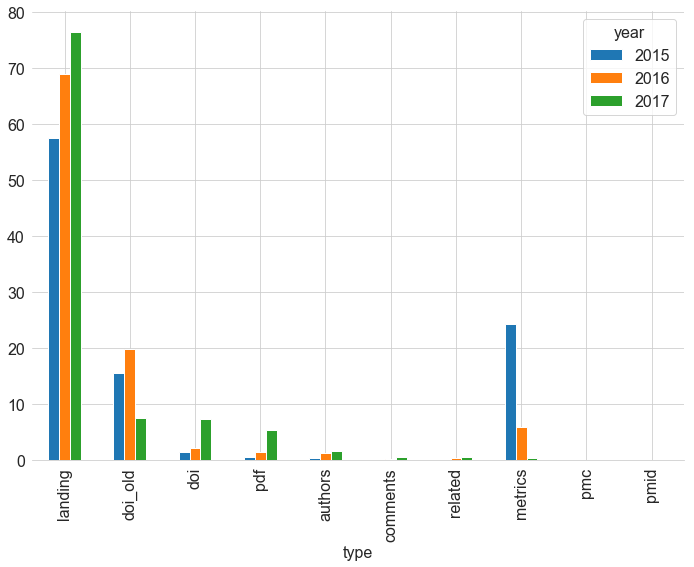

In [73]:
df.plot(kind="bar")
sns.despine(left=True, right=True, top=True)

### Which URLs were used to share articles?

#### Did the type of shared URLs change across years?

#### Do the types of shared URLs vary across disciplines?

### What kind of engagement did the articles receive?

#### Coverage of shares, reactions, and comments

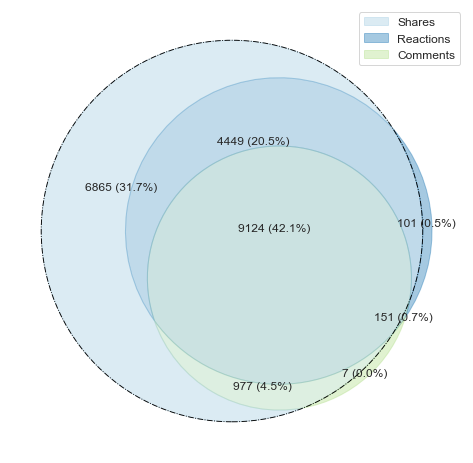

In [21]:
v = venn3(subsets= [all_shares, all_reactions, all_comments],
          set_labels=('', '', ''),
          subset_label_formatter=lambda x: "{} ({:.1f}%)".format(x, 100*x/len(any_engagement)));

c=venn3_circles(subsets= [all_shares, all_reactions, all_comments], linewidth=0)
c[0].set_lw(.9)
c[0].set_ls('-.')

v.get_patch_by_id('100').set_color(cp3[0])
v.get_patch_by_id('010').set_color(cp3[1])
v.get_patch_by_id('001').set_color(cp3[2])

v.get_patch_by_id('110').set_color(np.add(cp3[0],cp3[1])/2)
v.get_patch_by_id('011').set_color(np.add(cp3[1],cp3[2])/2)
v.get_patch_by_id('101').set_color(np.add(cp3[0],cp3[2])/2)

v.get_patch_by_id('111').set_color(np.add(np.add(cp3[1],cp3[0]), cp3[2]) / 3)

for text in v.set_labels:
    text.set_fontsize(12)
for text in v.subset_labels:
    text.set_fontsize(14)


for text in v.set_labels:
    text.set_fontsize(10)
for text in v.subset_labels:
    text.set_fontsize(12)

plt.gca().legend(handles=[v.get_patch_by_id('100'), v.get_patch_by_id('010'), v.get_patch_by_id('001')],
                 labels=["Shares", "Reactions", "Comments"], prop={'size': 12});

In [109]:
artics = articles[(articles.AES.isna()) & ((~articles.AER.isna()) | (~articles.AEC.isna()))]
artics.describe()

,pmid,year,AES,POS,TW,AER,AEC
count,2.590000e+02,259.000000,0.0,60.000000,202.000000,252.000000,158.000000
mean,2.616453e+07,2015.270270,NaN,1.266667,4.707921,23.214286,9.139241
std,7.057507e+05,0.524889,NaN,0.482461,5.467119,29.256417,9.666719
min,2.563409e+07,2015.000000,NaN,1.000000,1.000000,1.000000,1.000000
25%,2.576836e+07,2015.000000,NaN,1.000000,1.000000,4.000000,2.000000
50%,2.581630e+07,2015.000000,NaN,1.000000,3.000000,12.000000,6.000000
75%,2.603203e+07,2015.000000,NaN,1.250000,5.000000,30.000000,12.000000
max,2.874286e+07,2017.000000,NaN,3.000000,34.000000,159.000000,56.000000


#### Do the shared URL types receive different kinds of engagement?

### Analysis by groups: Do all articles receive the same types of engagement?

#### Correlations by groups

# Comparison of retrieval methods

In [25]:
# Difference between AES and POS counts
articles['diff'] = articles['AES'] - articles['POS']

# Remove articles in Arts and Humanities
base = articles[~articles.discipline.isin(["Arts", "Humanities"])]
"Removed {} articles in Arts or Humanities".format(articles[articles.discipline.isin(["Arts", "Humanities"])].shape[0])

'Removed 17 articles in Arts or Humanities'

### Coverage of Shares, Reactions, and Comments

In [20]:
print(articles[['AES', 'AER', 'AEC']].dropna(how="all").shape[0])
articles.describe()

21674


,pmid,year,AES,POS,TW,AER,AEC
count,6.184300e+04,61848.000000,21415.000000,9623.000000,43064.000000,13825.000000,10259.000000
mean,2.721320e+07,2015.873642,8.811674,2.301465,8.923718,53.535335,23.989668
std,1.080284e+06,0.824578,136.323191,4.804324,63.637819,475.446702,311.972031
min,2.555500e+07,2015.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.624747e+07,2015.000000,1.000000,1.000000,1.000000,4.000000,2.000000
50%,2.701101e+07,2016.000000,2.000000,1.000000,3.000000,16.000000,6.000000
75%,2.815831e+07,2017.000000,4.000000,2.000000,6.000000,46.000000,15.000000
max,2.928712e+07,2017.000000,12473.000000,186.000000,8626.000000,36030.000000,15840.000000


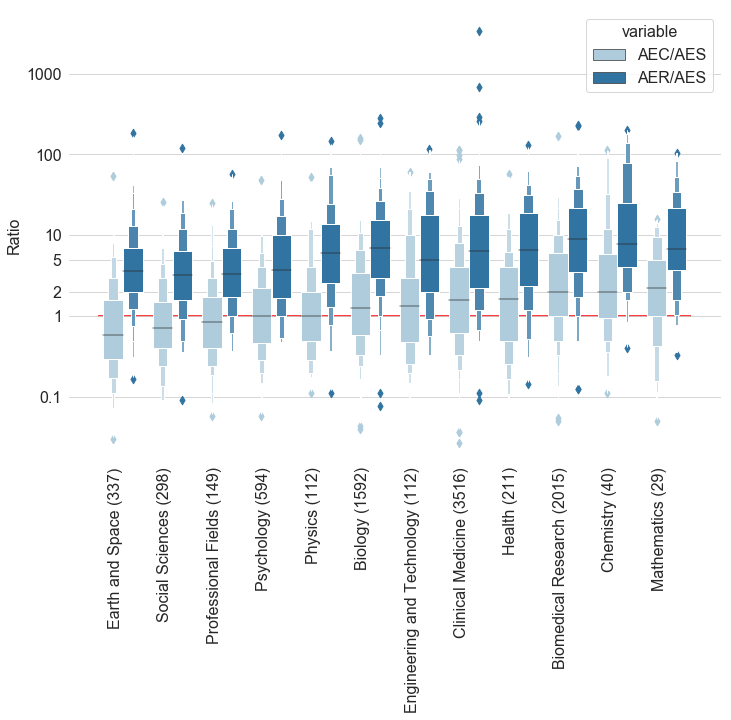

In [23]:
disc_counts = base.dropna(how="any", subset=['AES', 'AER', 'AEC']).disc.value_counts()

x = base.dropna(how="any", subset=['AES', 'AER', 'AEC'])[['disc', 'AES', 'AER', 'AEC']]
x['AER/AES'] = x['AER'] / x['AES']
x['AEC/AES'] = x['AEC'] / x['AES']
x = x.melt(id_vars="disc", value_vars=['AEC/AES', 'AER/AES']).dropna()

meds = x.groupby(["disc", "variable"])['value'].median().reset_index().groupby('disc')['variable', 'value'].apply(lambda x: x.iloc[0,1])
x['sort'] = x.disc.map(lambda x: meds[x])

x.disc = x.disc.map(lambda x: "{} ({})".format(x, disc_counts[x]))
x = x.sort_values(["sort"])

sns.boxenplot(x="disc", y="value", hue="variable", data=x, palette=cm)

plt.yscale("log")
xmin, xmax = plt.gca().get_xlim()
plt.hlines(1, xmin, xmax, zorder=-1, color="red")

yticks = [0.1, 1, 2, 5, 10, 100, 1000]
plt.yticks(yticks, yticks);

plt.xticks(rotation=45, ha="right");
plt.xticks(rotation=90)

plt.xlabel("")
plt.ylabel("Ratio")

sns.despine(left=True, right=True, top=True, bottom=True)

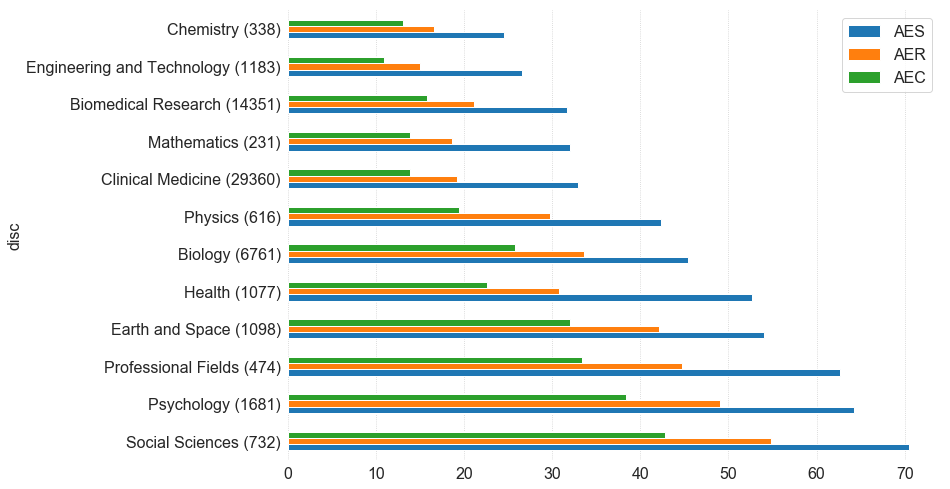

In [24]:
disc_counts = base.disc.value_counts()
x = base.groupby("disc")[['AES', 'AER', 'AEC']].count()
x = x.apply(lambda x: x.map(lambda y: 100*y/disc_counts[x.name]), axis=1)
x.index = x.index.map(lambda x: "{} ({})".format(x, disc_counts[x]))
x.sort_values("AES", ascending=False).plot(kind="barh")

plt.grid(False)
plt.grid(True, axis="x", linestyle=":")
sns.despine(left=True, top=True, right=True, bottom=True)

In [1]:
disc_counts = base.disc.value_counts()
x = base.groupby("disc")[['AES', 'AER', 'AEC']].count()
# x = x.apply(lambda x: x.map(lambda y: 100*y/disc_counts[x.name]), axis=1)
x.index = x.index.map(lambda x: "{} ({})".format(x, disc_counts[x]))

x['AER/AES'] = 100 * x['AER'] / x['AES']
x['AEC/AES'] = 100 * x['AEC'] / x['AES']
x[['AER/AES', 'AEC/AES']].sort_values('AEC/AES', ascending=False).plot(kind="barh")

plt.ylabel("")
ticks = list(range(0, 81, 10))
plt.xticks(ticks, ["{:,}%".format(int(_)) for _ in ticks])

plt.grid(False)
plt.grid(True, axis="x", linestyle=":")
sns.despine(left=True, top=True, right=True, bottom=True)

NameError: name 'base' is not defined

In [29]:
col = "disc"

cov_disciplines = base.groupby(col)[metrics].apply(lambda x: x.count())
cov_disciplines['All articles'] = base.groupby(col)[metrics].size()
cov_disciplines = cov_disciplines.sort_values("All articles", ascending=False)

# Column names + order
cov_disciplines.index.name = "Discipline"

##### Distribution of disciplines

##### Detailed look at Facebook

In [145]:
any_fb_counts = base.reindex(all_shares.union(am_shares))[col].value_counts()
any_fb_counts.loc['Total'] = any_fb_counts.sum()

/home/asura/.virtualenvs/altmetrics/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


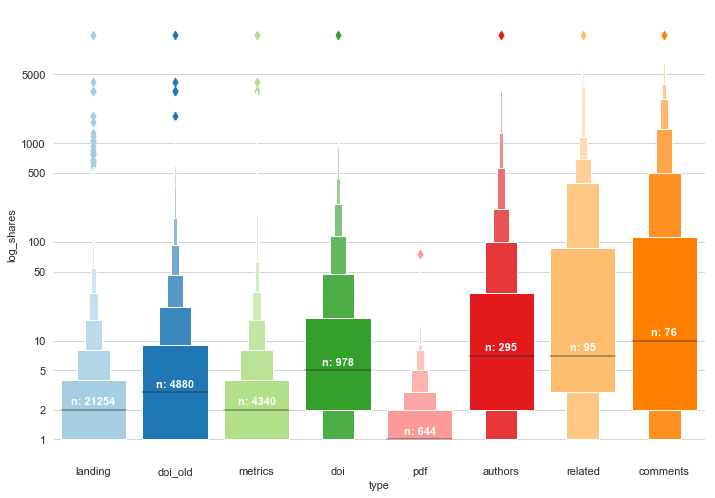

In [226]:
mask = nz_resp['type'].isin(["pmc", "pmid"])
pdf = nz_resp[~mask]
pdf['log_shares'] = pdf['shares'].map(lambda x: np.log10(x))

order = pdf.type.value_counts().keys().tolist()

ax = sns.boxenplot(x="type", y="log_shares", data=pdf,
                   saturation=1,
                   order=order, palette=cm)


medians = pdf.groupby(['type'])['log_shares'].median()
nobs = pdf['type'].value_counts()
nobs = nobs.map(lambda x: "n: {}".format(x))

pos = range(len(nobs))
for pos, label in enumerate(order):
    plt.text(pos, medians[label]+.05, nobs[label],
             horizontalalignment='center', color='w', weight='semibold')

ticks = [1, 2, 5, 10, 50, 100, 500, 1000, 5000]
plt.yticks(np.log10(ticks), ticks);

sns.despine(left=True, right=True, top=True, bottom=True);

# References

Milojević, S. (2010). Power law distributions in information science: Making the case for logarithmic binning. Journal of the American Society for Information Science and Technology, 61(12), 2417–2425. doi: 10/bm7ck6